<a href="https://colab.research.google.com/github/lanhhv84/machine-translation/blob/master/machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Machine Translation Project
In this notebook, sections that end with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully!

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/DS/lib/')

In [3]:
!sudo apt-get install libmysqlclient-dev
!pip install contractions
!pip install pattern

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libmysqlclient-dev
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 1,160 kB of archives.
After this operation, 6,995 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmysqlclient-dev amd64 5.7.26-0ubuntu0.18.04.1 [1,160 kB]
Fetched 1,160 kB in 2s (737 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: f

In [4]:
%load_ext autoreload
%aimport normalization
%autoreload 1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [0]:
import os


def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

In [0]:
import collections

import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

### Verify access to the GPU
The following test applies only if you expect to be using a GPU, e.g., while running in a Udacity Workspace or using an AWS instance with GPU support. Run the next cell, and verify that the device_type is "GPU".
- If the device is not GPU & you are running from a Udacity Workspace, then save your workspace with the icon at the top, then click "enable" at the bottom of the workspace.
- If the device is not GPU & you are running from an AWS instance, then refer to the cloud computing instructions in the classroom to verify your setup steps.

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7981125207760576519
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17408837859522900012
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12160127370090960921
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9399768410644753984
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [0]:
# Load English data
english_sentences = load_data(os.path.join(root, 'DS/data/nmt/small_vocab_en.txt'))
# Load French data
french_sentences = load_data(os.path.join(root, 'DS/data/nmt/small_vocab_fr.txt'))

In [9]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from importlib import reload
from normalization import normalize_corpus, create_vocabulary, to_onehot

In [0]:
english_sentences = normalize_corpus(english_sentences, tokenize=True)
french_sentences = normalize_corpus(french_sentences, tokenize=True)

In [0]:
START = '<S>'
END = '<E>'
UNK = '<U>'

In [0]:
en_w2i, en_i2w = create_vocabulary(english_sentences, start=START, end=END, unk=UNK)
fr_w2i, fr_i2w =  create_vocabulary(french_sentences, start=START, end=END, unk=UNK)


In [0]:
english_sentences = [[en_w2i.get(x, en_w2i[UNK]) for x in sent] for sent in english_sentences]
french_sentences = [[fr_w2i.get(x, fr_w2i[UNK]) for x in sent] for sent in french_sentences]

In [0]:
english_sentences = [[en_w2i[START]] + sent + [en_w2i[END]] for sent in english_sentences]
french_sentences = [[fr_w2i[START]] + sent + [fr_w2i[END]] for sent in french_sentences]

## Models
In this section, you will experiment with various neural network architectures.
You will begin by training four relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN
- Model 4 is an optional Encoder-Decoder RNN

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [0]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN (IMPLEMENTATION)
![RNN](https://github.com/lanhhv84/machine-translation/blob/master/images/rnn.png?raw=1)
A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

In [0]:
from keras import backend as K
def custom_sparse_categorical_accuracy(y_true, y_pred):
    return K.cast(K.equal(K.max(y_true, axis=-1),
                          K.cast(K.argmax(y_pred, axis=-1), K.floatx())),
                  K.floatx())

In [0]:
# GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional

def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 0.001
    input_seq = Input(input_shape[1:]) # Size, 101, 1
    rnn = GRU(64, return_sequences=True)(input_seq) # Size, 101, 64
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=[custom_sparse_categorical_accuracy])
    return model
tests.test_simple_model(simple_model)

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)


Instructions for updating:
Colocations handled automatically by placer.


NameError: name 'preproc_english_sentences' is not defined

In [0]:
#simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=100, validation_split=0.2)

# Print prediction(s)
#print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 2: Embedding (IMPLEMENTATION)
![RNN](https://github.com/lanhhv84/machine-translation/blob/master/images/embedding.png?raw=1)
You've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll create a RNN model using embedding.

In [0]:
from keras.layers import Reshape

def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate = 0.001
    input_seq = Input(input_shape[1:]) # Size, 101, 1
    embedded_seq = Embedding(input_dim=input_shape[0], output_dim=128)(input_seq)
    new_shape = [embedded_seq.shape[1].value, embedded_seq.shape[3].value]
    print(new_shape)
    rnn = GRU(64, return_sequences=True)(Reshape(new_shape)(embedded_seq)) # Size, 101, 64
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=[custom_sparse_categorical_accuracy])
    return model


# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
embedded_rnn_model = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

In [0]:
#embedded_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=3, validation_split=0.2)

# Print prediction(s)
#print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 3: Bidirectional RNNs (IMPLEMENTATION)
![RNN](https://github.com/lanhhv84/machine-translation/blob/master/images/bidirectional.png?raw=1)
One restriction of a RNN is that it can't see the future input, only the past.  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

In [0]:
# GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional

def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    
    learning_rate = 0.001
    input_seq = Input(input_shape[1:]) # Size, 101, 1
    embedded_seq = Embedding(input_dim=input_shape[0], output_dim=128)(input_seq)
    new_shape = [embedded_seq.shape[1].value, embedded_seq.shape[3].value]
    rnn = Bidirectional(GRU(64, return_sequences=True))(Reshape(new_shape)(embedded_seq)) # Size, 101, 64
    print(rnn.shape)
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    print(logits.shape)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=[custom_sparse_categorical_accuracy])
    return model
# tests.test_bd_model(bd_model)

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
bd_model = bd_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)


In [0]:
bd_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 4: Encoder-Decoder (OPTIONAL)
Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

Create an encoder-decoder model in the cell below.

In [0]:
from keras.layers import RepeatVector, LSTM, Flatten


def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 0.001
    input_seq = Input(input_shape[1:]) # Size, 101, 1
    embedded_seq = Embedding(input_dim=input_shape[0], output_dim=128)(input_seq)
    new_shape = [embedded_seq.shape[1].value, embedded_seq.shape[3].value]
    rnn_encoder = Bidirectional(LSTM(64, dropout=0.4))(Reshape(new_shape)(embedded_seq)) # Size, 101, 64
    new_shape2 = [rnn_encoder.shape[1].value, 1]
    rnn_decoder = LSTM(64, dropout=0.4)(Reshape(new_shape2)(rnn_encoder))
    # [?, Length, future]
    
    repeated_decoder = RepeatVector(output_sequence_length)(rnn_decoder)

    logits = TimeDistributed(Dense(french_vocab_size))(repeated_decoder)
    logits = Reshape([output_sequence_length, french_vocab_size])(logits)
    print(logits.shape)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=[custom_sparse_categorical_accuracy])
    return model
#tests.test_encdec_model(encdec_model)


# OPTIONAL: Train and Print prediction(s)

In [0]:
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
encoder_decoder = encdec_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

In [0]:
tmp_x.shape

In [0]:
encoder_decoder.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 5: Custom (Sequence-to-Sequence + Attention)
Use everything you learned from the previous models to create a model that incorporates embedding and a bidirectional rnn into one model.

In [0]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
english_sentences = english_sentences.reshape(*english_sentences.shape, 1)
french_sentences = french_sentences

In [0]:

import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm


class EncoderDecoder(torch.nn.Module):
    def __init__(self, input_length, output_length, english_vocab_size, french_vocab_size, device=None ,features=64):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        rnn_hidden = 64
        super(EncoderDecoder, self).__init__()
        self.features = features
        self.input_length = input_length
        self.output_length = output_length
        self.eng_embedding = nn.Embedding(english_vocab_size, features)
        self.enc_rnn = torch.nn.GRU(input_size= features, hidden_size=rnn_hidden, num_layers=1, bidirectional=False)
        self.device =device
        self.dec_rnn = torch.nn.GRU(input_size=rnn_hidden, hidden_size=rnn_hidden, num_layers=1, bidirectional=False)
        self.att = Variable(torch.randn(input_length, output_length))

        self.dense = torch.nn.Linear(in_features=features, out_features=french_vocab_size, bias=True)
        self.softmax = torch.nn.Sigmoid()
        #weight input_length, 1 => (1, output_length)
        self.a_w1 = Variable(torch.randn(1, input_length, self.features))
        self.a_w2 = Variable(torch.randn(1, input_length, 1))
        self.a_w = Variable(torch.randn(1, input_length, 1))
        self.m_w = Variable(torch.randn(1, input_length, self.features))
        
    def predict(self, inpu):
        hidden1 = None
        if isinstance(inpu, str):
            x = normalize_corpus([inpu], tokenize=True)[0]
            x = torch.LongTensor([en_w2i[a] for a in x]).to(self.device)
            x = self.eng_embedding(x)
            x = x.view(1, -1, self.features)
            encoder_hiddens = None
            for i in range(x.shape[1]):
                x_i = x[:, i, :].view(1, 1, -1)
                out, hidden1 = self.enc_rnn(x_i, hidden1)
                if encoder_hiddens is None:
                  encoder_hiddens = out.view(1, 1, self.features)
                else:
                  encoder_hiddens= torch.cat([encoder_hiddens, out.view(1, 1, self.features)], dim=1)
            output = []
            ans = None
            hidden2 = None
            encoder_hiddens # (1, input_length, self.features)
            index = 0
            fixed_inputlength = self.att.shape[0]
            input_inputlength = x.shape[1]
            # hidden (1, input_inputlength, self.features)  attention (1, fixed_inputlength, 1)
            isEnd = False
            if input_inputlength < fixed_inputlength:
                    encoder_hiddens = torch.cat([encoder_hiddens, torch.zeros((1, fixed_inputlength - input_inputlength, encoder_hiddens.shape[2])).to(self.device)], dim=1)
            while not isEnd:
                if input_inputlength > fixed_inputlength:
                    out, hidden2 = self.dec_rnn(self.score(encoder_hiddens[:, index: index + fixed_inputlength, :], self.att[:, i]).view(1, 1, -1), hidden2)
                else:
                    out, hidden2 = self.dec_rnn(self.score(encoder_hiddens, self.att[:, i]).view(1, 1, -1), hidden2)
                out = self.dense(out.view(1, -1)) # => (1, vocab_len)
                label = torch.argmax(out)
                if out[0][label] < 0.5:
                    isEnd = True
                else:
                    output.append(fr_i2w[label.data.cpu().item()])
            index = index + 1
            return output
        

    def forward(self, inv):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        ans = None
        x_embed = self.eng_embedding(inv)
        batch_size = inv.shape[0]
        input_length = inv.shape[1]
        # (1000, 21, 1, features)
        x = x_embed.view(batch_size, -1, self.features)
        # (1000, 21, features)
        # (1000, 1, features)
        encoder_hiddens = None
        hidden1 = None
        hidden2 = None
        for i in range(x.shape[1]):
            x_i = x[:, i, :].view(batch_size, 1, -1)
            out, hidden1 = self.enc_rnn(x_i, hidden1)
            if encoder_hiddens is None:
                encoder_hiddens = out.view(batch_size, 1, self.features)
            else:
                encoder_hiddens= torch.cat([encoder_hiddens, out.view(batch_size, 1, self.features)], dim=1)


        ans = None
        for i in range(self.output_length):
            out, hidden2 = self.dec_rnn(self.multiplicative_scoring(encoder_hiddens, self.att[:, i]).view(batch_size, 1, -1), hidden2)
            out = self.dense(out.view(batch_size, -1))
            if ans is None:
                ans = out.view(batch_size, 1, -1)
            else:
                ans = torch.cat([ans, out.view(batch_size, 1, -1)], dim=1)
        return ans

    def score(self, hiddens, weight):
        w = weight.view(1, weight.shape[0], 1)
        # hidden, weight torch.Size([32, 15, 64]) torch.Size([1, 15, 1])
        return torch.sum(torch.mul(hiddens, w), dim=1)
    def additive_scoring(self, hiddens, weight):
        w = weight.view(1, weight.shape[0], 1)
        # hidden, weight torch.Size([32, 15, 64]) torch.Size([1, 15, 1])
        
        # f = va*(w1*hidden + w2*hidden)
        
        
        # 32, 1, 64 => (Batch, 1, Features)
        
        ans = torch.mul(self.a_w, torch.tanh(torch.mul(hiddens, self.a_w1) + torch.mul(w, self.a_w2)))
        return torch.sum(ans, dim=1)
    
    def multiplicative_scoring(self, hiddens, weight):
        w = weight.view(1, weight.shape[0], 1)
        # hidden, weight torch.Size([32, 15, 64]) torch.Size([1, 15, 1])
        
        # f = va*(w1*hidden + w2*hidden)
        
        
        # 32, 1, 64 => (Batch, 1, Features)
        
        ans = torch.mul(self.m_w, torch.mul(hiddens, w))
        return torch.sum(ans, dim=1)
    
    def cross_entropy(self, size_average=True):
        def calculate(input, target):
            logsoftmax = nn.LogSoftmax(dim=-1)
            if size_average:
              return torch.mean(torch.sum(-target * logsoftmax(input), dim=1))
            else:
              return torch.sum(torch.sum(-target * logsoftmax(input), dim=1))
        return calculate

    def train(self, x, y, batch_size=32, epochs=10, vocab_len=100):
        criterion = self.cross_entropy(False)
        optimizer = torch.optim.Adam(model.parameters())
        from tqdm import tqdm_notebook as tqdm
        import math
        n_batches = math.ceil(x.shape[0] / batch_size)
        for t in range(epochs):
            # Forward pass: Compute predicted y by passing x to the model
            total = 0
            for i in tqdm(range(n_batches)):
                inp = torch.LongTensor(x[i*batch_size:min(i*batch_size + batch_size, x.shape[0]), :, :]).to(self.device)
                labels = to_onehot(y[i*batch_size:min(i*batch_size + batch_size, x.shape[0]), :], vocab_len, torch.zeros).to(self.device)
                y_pred = self(inp)
                # Compute and print loss
                loss = criterion(y_pred, labels)
                total += loss.item()

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            checkpoint = {'model': self, 'state_dict': self.state_dict(), 'optimizer' : optimizer.state_dict()}
            print(t, total)
    def to(self, device):
        new_self = super(EncoderDecoder, self).to(device)
        new_self.a_w1 = self.a_w1.to(device)
        new_self.a_w2 = self.a_w2.to(device)
        new_self.a_w = self.a_w.to(device)
        new_self.att = self.att.to(device)
        new_self.m_w = self.m_w.to(device)
        return new_self
        
    

model = EncoderDecoder(input_length=english_sentences.shape[1], output_length=french_sentences.shape[1], english_vocab_size=len(en_w2i), french_vocab_size=len(fr_w2i), device=device)

In [0]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [0]:
model.train(english_sentences, french_sentences,batch_size=32, epochs=100, vocab_len=len(fr_w2i))

TypeError: ignored

### Model 5.1

     |████████████████████████████████| 92kB 5.8MB/s 


In [0]:
import torch
from torchnlp.nn.weight_drop import WeightDrop
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
import torch
from torch.nn import Parameter
from functools import wraps

class WeightDrop(torch.nn.Module):
    def __init__(self, module, weights, dropout=0, variational=False):
        super(WeightDrop, self).__init__()
        self.module = module
        self.weights = weights
        self.dropout = dropout
        self.variational = variational
        self._setup()

    def widget_demagnetizer_y2k_edition(*args, **kwargs):
        # We need to replace flatten_parameters with a nothing function
        # It must be a function rather than a lambda as otherwise pickling explodes
        # We can't write boring code though, so ... WIDGET DEMAGNETIZER Y2K EDITION!
        # (╯°□°）╯︵ ┻━┻
        return

    def _setup(self):
        # Terrible temporary solution to an issue regarding compacting weights re: CUDNN RNN
        if issubclass(type(self.module), torch.nn.RNNBase):
            self.module.flatten_parameters = self.widget_demagnetizer_y2k_edition

        for name_w in self.weights:
            print('Applying weight drop of {} to {}'.format(self.dropout, name_w))
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = None
            if self.variational:
                mask = torch.autograd.Variable(torch.ones(raw_w.size(0), 1))
                if raw_w.is_cuda: mask = mask.cuda()
                mask = torch.nn.functional.dropout(mask, p=self.dropout, training=True)
                w = mask.expand_as(raw_w) * raw_w
            else:
                w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
            setattr(self.module, name_w, w)

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)


In [0]:

import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Sequence2Sequence(torch.nn.Module):
    def __init__(self, end_val, input_vocab_size, embedding_size, output_vocab_size, encoder_hidden_features, decoder_hidden_features, encoder_output_features, embed=True):
        super(Sequence2Sequence, self).__init__()
        # Encoder
        if embed:
            self.embedding = nn.Embedding(num_embeddings=input_vocab_size, embedding_dim=embedding_size)
        else:
            self.embedding = nn.Linear(embedding_size, embedding_size)
        
        self.ernn_undrop = nn.LSTM(input_size=embedding_dim, batch_first=True, bidirectional=True, hidden_size=encoder_hidden_features, num_layers=2, dropout=0.4)
        self.ernn2_undrop = nn.LSTM(input_size=encoder_hidden_features, batch_first=True, bidirectional=True, hidden_size=encoder_output_features, num_layers=2, dropout=0.4)
        
        n_layers = 2
        ernnw = ['weight_hh_l' + str(i) for i in range(n_layers)]
        self.ernn2 = WeightDrop(self.ernn2_undrop, weights=ernnw,dropout=0.5)
        self.ernn = WeightDrop(self.ernn_undrop, weights=ernnw,dropout=0.5)
        

        
        # Decoder
        self.undrop_drnn = nn.LSTM(input_size=encoder_output_features, hidden_size=decoder_hidden_features, num_layers=2, dropout=0.4)
        self.drnn = WeightDrop(self.undrop_drnn, weights=ernnw,dropout=0.5)
        self.ddense = nn.Linear(decoder_hidden_features, output_vocab_size)
        
        # Attn
        self.Wa = nn.Linear(decoder_hidden_features*2, encoder_output_features)
        self.E = []
        self.end_val = end_val
    
    def forward(self, input_tensor, max_output_length, device, end_val=0):
        embedded_input = self.embedding(input_tensor)
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        x = embedded_input.view(batch_size, input_length, -1)
        ehiddens = None
        ehidden = None
        dhidden = None
        ans = None
        self.E = []
        # Encode input
        ehiddens, _ = self.ernn(x)
        ehiddens = ehiddens[:, :,  :self.ernn.module.hidden_size] + ehiddens[:, : ,self.ernn.module.hidden_size:]
        ehiddens, _ = self.ernn2(ehiddens)
        ehiddens = ehiddens[:, :,  :self.ernn2.module.hidden_size] + ehiddens[:, : ,self.ernn2.module.hidden_size:]
        # Decode
        if dhidden is None:
            dhidden = (torch.zeros(2, 1, self.drnn.module.hidden_size).to(device), torch.zeros(2, 1, self.drnn.module.hidden_size).to(device))
        self.E.append(self.fatt(ehiddens, torch.cat(dhidden[1][-1, :, :], dhidden[0][-1, :, :], dim=0)))
        for i in range(max_output_length):
            ei = self.E[i] # (batch_size, input_length, encoder_hidden)
            # Expect alphai: # (batch_size, @input_length)
            alphai = torch.softmax(ei, dim=2) # (batch_size, @input_length, encoder_hidden)
            ci = torch.sum(torch.mul(alphai, ehiddens), dim=1).view(batch_size, 1, -1) # (batch_size, 1, encoder_features)
            out, dhidden = self.drnn(ci, dhidden)
            self.E.append(self.fatt(ehiddens, torch.cat(dhidden[1][-1, :, :], dhidden[0][-1, :, :], dim=0)))
            out = self.ddense(out.view(batch_size, -1))
            if ans is None:
                ans = out.view(batch_size, 1, -1)
            else:
                ans = torch.cat([ans, out.view(batch_size, 1, -1)], dim=1)
        return ans
    
    def predict(self, input_tensors, max_output_length, device, end_val=0):
        
        embedded_input = self.embedding(input_tensor)
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        x = embedded_input.view(batch_size, input_length, -1)
        ehiddens = None
        ehidden = None
        dhidden = None
        ans = None
        self.E = []
        # Encode input
        ehiddens, _ = self.ernn(x)
        ehiddens = ehiddens[:, :,  :self.ernn.hidden_size] + ehiddens[:, : ,self.ernn.hidden_size:]
        ehiddens, _ = self.ernn2(ehiddens)
        ehiddens = ehiddens[:, :,  :self.ernn2.hidden_size] + ehiddens[:, : ,self.ernn2.hidden_size:]
        # Decode
        if dhidden is None:
            dhidden = torch.zeros(1, self.drnn.hidden_size).to(device)
        self.E.append(self.fatt(ehiddens, dhidden))
        for i in range(max_output_length):
            ei = self.E[i] # (batch_size, input_length, encoder_hidden)
            # Expect alphai: # (batch_size, @input_length)
            alphai = torch.softmax(ei, dim=2) # (batch_size, @input_length, encoder_hidden)
            
            ci = torch.sum(torch.mul(alphai, ehiddens), dim=1).view(batch_size, 1, -1) # (batch_size, 1, encoder_features)
            out, dhidden = self.drnn(ci, dhidden[0])
            self.E.append(self.fatt(ehiddens, dhidden[0]))
            out = self.ddense(out.view(batch_size, -1))
            if ans is None:
                ans = out.view(batch_size, 1, -1)
            else:
                ans = torch.cat([ans, out.view(batch_size, 1, -1)], dim=1)
        return ans
    
    def predict_one(self, input_tensor, max_output_length, device, end_val=0):
        embedded_input = self.embedding(input_tensor.view(1, input_tensor.shape[0]))
        batch_size = 1
        input_length = input_tensor.shape[0]
        x = embedded_input.view(batch_size, input_length, -1)
        ehiddens = None
        ehidden = None
        dhidden = None
        ans = None
        self.E = []
        ret = []
        # Encode input
        ehiddens, _ = self.ernn(x)
        ehiddens = ehiddens[:, :,  :self.ernn.module.hidden_size] + ehiddens[:, : ,self.ernn.module.hidden_size:]
        ehiddens, _ = self.ernn2(ehiddens)
        ehiddens = ehiddens[:, :,  :self.ernn2.module.hidden_size] + ehiddens[:, : ,self.ernn2.module.hidden_size:]
        # Decode
        if dhidden is None:
            dhidden = (torch.zeros(2, 1, self.drnn.hidden_size).to(device), torch.zeros(2, 1, self.drnn.hidden_size).to(device))
        self.E.append(self.fatt(ehiddens, dhidden[0] + dhidden[1]))
        for i in range(max_output_length):
            ei = self.E[i] # (batch_size, input_length, encoder_hidden)
            # Expect alphai: # (batch_size, @input_length)
            alphai = torch.softmax(ei, dim=2) # (batch_size, @input_length, encoder_hidden)
            
            ci = torch.sum(torch.mul(alphai, ehiddens), dim=1).view(batch_size, 1, -1) # (batch_size, 1, encoder_features)
            out, dhidden = self.drnn(ci, dhidden)
            self.E.append(self.fatt(ehiddens, dhidden[0] + dhidden[1]))
            out = self.ddense(out.view(batch_size, -1))
            label = torch.softmax(out.view(-1), dim=0)
            ret.append(torch.argmax(label).item())
            if ret[-1] == end_val:
                return ret
            if ans is None:
                ans = out.view(batch_size, 1, -1)
            else:
                ans = torch.cat([ans, out.view(batch_size, 1, -1)], dim=1)
        return ret
        
   
    
    def fatt(self, ehiddens, dhidden):
        # (batch_size, @input_length, encoder_features)
        # W_a = (decoder_hidden_features, encoder_output_features)
        # (batch_size, 1, decoder_features)
        batch_size = ehiddens.shape[0]
        input_length = ehiddens.shape[1]
        
        s = self.Wa(dhidden.view(1, -1)).view(1, 1, -1) # => (batch_size, 1, encoder_feature)
        # return (batch_size, @input_length, encoder_features)
        return torch.mul(s, ehiddens)
    
    def train(self, device, batches, saved_loss, print_step=100, save_step=10, batch_size=32,  epochs=10, optimizer=torch.optim.Adam):
        import os 
        PATH = os.path.join('/content/drive/My Drive/DS/checkpoints', 'nmt.weights')
        optimizer = optimizer(self.parameters())
        criterion = self.cross_entropy(False)
        
        for t in range(epochs):
            # Forward pass: Compute predicted y by passing x to the model
            total = 0

            for index, (inp, labels) in enumerate(batches):
                y_pred = self(inp, max_output_length=labels.shape[1], device=device)
                # Compute and print loss
                loss = criterion(y_pred, labels)
                total += loss.item()

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if index % save_step == 0:
                    saved_loss.append(loss)
                if index % print_step ==0:
                    print("Epoch {} [{}/{}] Loss: {}".format(t + 1, index + 1, len(batches), loss))
            torch.save(self.state_dict(), PATH)
            print('Save model to {}'.format(PATH))
            print("Epoch {} Total Loss: {}".format(t, total))
            
            
    def input2tensor(self, X, device):
        """
            X: [0, .., 1]
        """
        return torch.LongTensor(X)
        
    def get_batches(self, X, Y, device, batch_size=32):
        import math
        n_batches = math.ceil(len(X) / batch_size)
        for i in range(n_batches):
            lower = i*batch_size 
            upper = min(len(X), lower + batch_size)
            x, y = X[lower:upper], Y[lower:upper]
            x = [torch.LongTensor(_x) for _x in x]
            y = [torch.LongTensor(_x) for _x in y]
            x = torch.nn.utils.rnn.pad_sequence(x, padding_value=en_w2i[END]).t()
            y = torch.nn.utils.rnn.pad_sequence(y, padding_value=fr_w2i[END]).t().numpy()
            y = torch.FloatTensor(to_onehot(y, len(fr_w2i)))
            yield x.to(device), y.to(device)
            
        
        
    def cross_entropy(self, size_average=True):
        def calculate(input, target):
            logsoftmax = nn.LogSoftmax(dim=-1)
            if size_average:
                return torch.mean(torch.sum(-target * logsoftmax(input), dim=1))
            else:
                return torch.sum(torch.sum(-target * logsoftmax(input), dim=1))
        return calculate

In [0]:
ivocab_size = len(en_w2i)
ovocab_size = len(fr_w2i)
embedding_dim = 128
ehidden = 64
dhidden = 64
eout = 128

In [0]:
model = Sequence2Sequence(en_w2i[END],input_vocab_size=ivocab_size, embedding_size=embedding_dim,  output_vocab_size=ovocab_size, encoder_hidden_features=ehidden, decoder_hidden_features=dhidden, encoder_output_features=eout)
model = model.to(device)

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l1
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l1
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l1


In [0]:
# PATH = os.path.join('/content/drive/My Drive/DS/checkpoints', 'nmt.weights')
# model.load_state_dict(torch.load(PATH), strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
batches = model.get_batches(english_sentences, french_sentences, device, batch_size=128)
batches = list(batches)
saved_loss = []

In [0]:
x = batches[0][0][31]
model.predict_one(x, 20, device)

[1, 12, 20, 35, 79, 35, 14, 14, 37, 12, 12, 12, 12, 5, 5, 5, 5, 5, 5, 5]

In [0]:
x = batches[0][1][31]
print(torch.argmax(x, dim=-1))

tensor([ 1, 39, 76,  5, 35, 79, 22, 14, 46, 11, 12,  5, 47, 14, 15,  0,  0,  0,
         0,  0,  0], device='cuda:0')


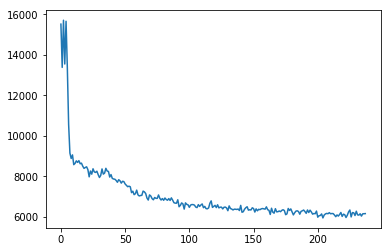

In [0]:
import matplotlib.pyplot as plt
plt.plot(saved_loss)

In [0]:
hist = model.train(device, batches, saved_loss=saved_loss, batch_size=128, epochs=20)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:522: RuntimeWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  self.dropout, self.training, self.bidirectional, self.batch_first)


Epoch 1 [1/1078] Loss: 15497.86328125
Epoch 1 [101/1078] Loss: 9209.19921875
Epoch 1 [201/1078] Loss: 8779.02734375
Epoch 1 [301/1078] Loss: 8440.48046875
Epoch 1 [401/1078] Loss: 8155.6044921875
Epoch 1 [501/1078] Loss: 8545.1123046875
Epoch 1 [601/1078] Loss: 8425.0712890625
Epoch 1 [701/1078] Loss: 8015.515625
Epoch 1 [801/1078] Loss: 8182.7451171875
Epoch 1 [901/1078] Loss: 8132.951171875
Epoch 1 [1001/1078] Loss: 7894.8359375


KeyboardInterrupt: ignored

### Model 6: Transformer

In [0]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.nn.init as init

In [0]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim=512, dmodel=64, nhead=8):
        super(MultiHeadAttention, self).__init__()
        # Q
        Wq = torch.zeros(embedding_dim, dmodel, nhead)
        init.uniform_(Wq)
        self.Wq = nn.Parameter(Wq)
        # K
        Wk = torch.zeros(embedding_dim, dmodel, nhead)
        init.uniform_(Wk)
        self.Wk = nn.Parameter(Wk)
        # V
        Wv = torch.zeros(embedding_dim, dmodel, nhead)
        init.uniform_(Wv)
        self.Wv = nn.Parameter(Wv)
        # O
        Wo = torch.zeros(dmodel*nhead, dmodel*nhead)
        init.uniform_(Wo)
        self.Wo = nn.Parameter(Wo)
        # Qb
        Bq = torch.zeros(1, embedding_dim)
        init.uniform_(Bq)
        self.Bq = nn.Parameter(Bq)
        # Kb
        Bk = torch.zeros(1, embedding_dim)
        init.uniform_(Bk)
        self.Bk = nn.Parameter(Bk)
        # Vb
        Bv = torch.zeros(1, embedding_dim)
        init.uniform_(Bv)
        self.Bv = nn.Parameter(Bv)
        
        # Parameters
        self.embedding_dim = embedding_dim
        self.nhead = nhead
        self.dmodel = dmodel
        
    def forward(self, input, mask=None):
        # input: batch_size, seqlen, embedding_dim
        batch_size = input.shape[0]
        seqlen = input.shape[1]
        new_shape = (batch_size, seqlen, self.embedding_dim, self.dmodel, self.nhead)
        # (batch_size, seqlen, embedding_dim, dmodel, nhead)
        # TODO: Positional encoding
        Q = torch.matmul(input.view(-1, self.embedding_dim), self.Wq.view(self.embedding_dim, -1)) + self.Bq.view(1, self.embedding_dim)
        # (batch_size*seqlen, 512)
        K = torch.matmul(input.view(-1, self.embedding_dim), self.Wk.view(self.embedding_dim, -1)) + self.Bk.view(1, self.embedding_dim)
        # (batch_size*seqlen, 512)
        V = torch.matmul(input.view(-1, self.embedding_dim), self.Wv.view(self.embedding_dim, -1)) + self.Bv.view(1, self.embedding_dim)
        # (batch_size*seqlen, 512)
        Q = Q.view(batch_size*seqlen, self.dmodel, self.nhead)
        K = K.view(batch_size*seqlen, self.dmodel, self.nhead)
        V = V.view(batch_size*seqlen, self.dmodel, self.nhead)
        
        heads = [(Q[:, :, i], K[:, :, i], V[:, :, i]) for i in range(self.nhead)]
        Zs = []
        # [(batch_size*seqlen, 64)*nhead]
        for i in range(len(heads)):
            q, k, v = heads[i]
            A = torch.softmax(torch.matmul(q, k.transpose(1, 0)), dim=1)
            # (batch_size*seqlen, batch_size*seqlen)
            A = A / 8
            Z = torch.matmul(A, v) # (batch_size*seqlen, 64)
            Zs.append(Z)
        # Zs: (batch_size*seqlen, 64)*nhead
        
        Z = torch.cat(Zs, dim=1) # (batch_size*seqlen, 512)
        Z = torch.matmul(Z, self.Wo) # (batch_size*seqlen, 512)
        return Z.view(batch_size, seqlen, self.dmodel*self.nhead) # (batch_size, seqlen, 512)
    
    def to(self, device):
        new_self = super(MultiHeadAttention, self).to(device)
        new_self.Wq = self.Wq.to(device)
        new_self.Wk = self.Wk.to(device)
        new_self.Wv = self.Wv.to(device)
        new_self.Wo = self.Wo.to(device)
        
        new_self.Bq = self.Bq.to(device)
        new_self.Bk = self.Bk.to(device)
        new_self.Bv = self.Bv.to(device)
        
        return new_self
        
    
    

In [0]:
class AddNorm(nn.Module):
    
    def __init__(self, features, forward_func, new_shape=None):
        super(AddNorm, self).__init__()
        self.features = features
        self.bn = nn.BatchNorm1d(num_features=features)
        self.new_shape = new_shape
        self.forward_func = forward_func
        
    def forward(self, input, func=None):
        output = self.forward_func(input)
        if not self.new_shape is None:
            output = output.view(*self.new_shape)
        output = output+input
        if not func is None:
            output = func(output)
        old_shape = output.shape
        return self.bn(output.contiguous().view(-1, self.features)).view(*old_shape)
    
    def to(self, device):
        new_self = super(AddNorm, self).to(device)
        new_self.bn = self.bn.to(device)
        
        return new_self

In [0]:
class Encoder(nn.Module):
    
    def __init__(self, vocab_size, attn):
        super(Encoder, self).__init__()
        self.attn = attn
        # Feed Forward network
        self.ff = nn.Linear(attn.dmodel*attn.nhead, attn.embedding_dim)
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(num_features=attn.embedding_dim)
        self.bn2 = nn.BatchNorm1d(num_features=attn.embedding_dim)
        # Add norm
        self.addNorm1 = AddNorm(attn.embedding_dim, self.attn)
        self.addNorm2 = AddNorm(attn.embedding_dim, self.ff, new_shape=(-1, self.attn.dmodel*self.attn.nhead))
        
        
    def forward(self, input):
        """
        In: (batch_size, seqlen, embedding)
        Out: (batch_size, seqlen, embedding)
        """
        batch_size = input.shape[0]
        seqlen = input.shape[1]
        
        input_score = self.addNorm1(input, func=lambda x: x.permute(0, 2, 1))
        
        out = []
        for i in range(input_score.shape[2]):
            single_out = self.addNorm2(input_score[:, :, i])
            out.append(single_out.view(*single_out.shape, 1))
        out = torch.cat(out, dim=2) # batch_size, self.embedding_dim,  seqlen
        return out.permute(0, 2, 1).contiguous()
    
    def to(self, device):
        new_self = super(Encoder, self).to(device)
        new_self.ff = self.ff.to(device)
        new_self.bn1 = self.bn1.to(device)
        new_self.bn2 = self.bn2.to(device)
        new_self.addNorm1 = self.addNorm1.to(device)
        new_self.addNorm2 = self.addNorm2.to(device)
        new_self.attn = self.attn.to(device)
        
        return new_self

In [0]:
class Decoder(nn.Module):
    
    def __init__(self, embedding_dim, masked_attn, attn):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.masked_attn = masked_attn
        self.attn = attn
        
        self.addNorm1 = AddNorm(embedding_dim, self.masked_attn)
        self.bn2 = nn.BatchNorm1d(num_features=embedding_dim)
        
        self.ff = nn.Linear(embedding_dim, embedding_dim)
        self.bn3 = nn.BatchNorm1d(num_features=embedding_dim)
    
    def forward(self, memory, encoder_state):
        """
        input =  (batch_size, 1, embedding_dim)
        """
        # Block 1
        mem = memory
        if not mem is None:
            mem = self.addNorm1(mem)
            nextIn = torch.cat([encoder_state, mem], dim=1)
        else:
            nextIn = encoder_state
        ### Block 2
        
        immediate = self.attn(nextIn)
        if not mem is None:
            immediate = torch.cat([immediate, mem], dim=1)
        old_shape = immediate.shape
        immediate = self.bn2(immediate.view(-1, self.embedding_dim)).view(*old_shape)[:, -1, :]
        
        ### Block 3
        block3 = self.bn3(immediate + self.ff(immediate.view(-1, self.embedding_dim)).view(*immediate.shape))
        return block3.reshape(-1, 1, self.embedding_dim)
        
    def to(self, device):
        new_self = super(Decoder, self).to(device)
        new_self.masked_attn = self.masked_attn.to(device)
        new_self.bn3 = self.bn3.to(device)
        new_self.bn2 = self.bn2.to(device)
        new_self.addNorm1 = self.addNorm1.to(device)
        new_self.attn = self.attn.to(device)
        
        return new_self     
            
            
      
        

In [0]:
class EncoderSet(nn.Module):
    def __init__(self, vocab_size, embedding_dim=512, dmodel=64, nhead=8, nencoder=6):
        super(EncoderSet, self).__init__()
        # Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Encoders
        self.encoders = []
        for i in range(nencoder):
            attn = MultiHeadAttention(embedding_dim=embedding_dim, dmodel=dmodel, nhead=nhead)
            encoder = Encoder(vocab_size=vocab_size, attn=attn)
            self.encoders.append(encoder)
        
    def forward(self, input):
        input = self.embedding(input)
        for encoder in self.encoders:
            input = encoder(input)
        return input
        
    def to(self, device):
        new_self = super(EncoderSet, self).to(device)
        new_self.embedding = self.embedding.to(device)
        new_self.encoders = [encoder.to(device) for encoder in self.encoders]
        
        return new_self    

In [0]:
class DecoderSet(nn.Module):
    def __init__(self, vocab_size, embedding_dim=512, dmodel=64, nhead=8, ndecoder=6):
        super(DecoderSet, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.decoders = []
        for i in range(ndecoder):
            mattn = MultiHeadAttention()
            attn = MultiHeadAttention()
            decoder = Decoder(embedding_dim=embedding_dim, masked_attn=mattn, attn=attn)
            self.decoders.append(decoder)
        
        self.embedding_dim = embedding_dim
        self.linear = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, encoder_state, maxseqlen=20, endIndex=0):
        memory = None
        ret = None
        for i in range(maxseqlen):
            init_state=memory
            for j in range(len(self.decoders)):
                out = self.decoders[j](memory=init_state, encoder_state=encoder_state)
            out = torch.relu(self.linear(out.view(-1, self.embedding_dim)))
            out = torch.softmax(out, dim=1)
            if ret is None:
                ret = out.view(encoder_state.shape[0], 1, -1)
            else:
                ret = torch.cat([ret, out.view(encoder_state.shape[0], 1, -1)], dim=1)
            index = torch.argmax(out, dim=1).long()
            out = self.embedding(index)
            out = out.view(out.shape[0], 1, -1)
            if memory is None:
                memory = out
            else:
                memory = torch.cat([memory, out], dim=1)
        return ret
        
    def predict(self, encoder_state, maxseqlen=20, endIndex=0):
        memory = None
        ret = None
        for i in range(maxseqlen):
            init_state=memory
            for j in range(len(self.decoders)):
                out = self.decoders[j](memory=init_state, encoder_state=encoder_state)
            out = torch.relu(self.linear(out.view(-1, self.embedding_dim)))
            out = torch.softmax(out, dim=1)
            if ret is None:
                ret = out.view(encoder_state.shape[0], 1, -1)
            else:
                ret = torch.cat([ret, out.view(encoder_state.shape[0], 1, -1)], dim=1)
            index = torch.argmax(out, dim=1).long()
            out = self.embedding(index)
            out = out.view(out.shape[0], 1, -1)
            if memory is None:
                memory = out
            else:
                memory = torch.cat([memory, out], dim=1)
            if torch.all(index == endIndex):
                return ret
        return ret
    
    def to(self, device):
        new_self = super(DecoderSet, self).to(device)
        new_self.embedding = self.embedding.to(device)
        new_self.linear = self.linear.to(device)
        new_self.decoders = [encoder.to(device) for encoder in self.decoders]
        
        return new_self    

In [0]:
from tqdm import tqdm_notebook as tqdm

class Transformer(nn.Module):
    
    def __init__(self, in_vocab_size, out_vocab_size, embedding_dim=512, dmodel=64, nhead=8, nencoder=6, ndecoder=6):
        super(Transformer, self).__init__()
        
        self.encoder = EncoderSet(vocab_size=in_vocab_size, embedding_dim=embedding_dim, dmodel=dmodel, nhead=nhead, nencoder=nencoder)
        self.decoder = DecoderSet(vocab_size=out_vocab_size, embedding_dim=embedding_dim, dmodel=dmodel, nhead=nhead, ndecoder=ndecoder)
        
    def forward(self, input, maxoutput=20, end=0):
        encoder_state = self.encoder(input)
        decoder_state = self.decoder(encoder_state, maxseqlen=maxoutput, endIndex=end)
        return decoder_state
    
    def train(self, device, batches, saved_loss, print_step=100, save_step=10, batch_size=32,  epochs=10, optimizer=torch.optim.Adam):
        import os 
        PATH = os.path.join('/content/drive/My Drive/DS/checkpoints', 'nmt.weights')
        optimizer = optimizer(self.parameters())
        criterion = self.cross_entropy(False)
        
        for t in tqdm(range(epochs)):
            # Forward pass: Compute predicted y by passing x to the model
            total = 0

            for index, (inp, labels) in tqdm(enumerate(batches), total=len(batches)):
                y_pred = self(inp, maxoutput=labels.shape[1])
                # Compute and print loss
                loss = criterion(y_pred, labels)
                total += loss.item()

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if index % save_step == 0:
                    saved_loss.append(loss)
                if index % print_step ==0:
                    print("Epoch {} [{}/{}] Loss: {}".format(t + 1, index + 1, len(batches), loss))
            torch.save(self.state_dict(), PATH)
            print('Save model to {}'.format(PATH))
            print("Epoch {} Total Loss: {}".format(t, total))
            
    def cross_entropy(self, size_average=True):
        def calculate(input, target):
            if size_average:
                return torch.mean(torch.sum(-target * torch.log(input), dim=1))
            else:
                return torch.sum(torch.sum(-target * torch.log(input), dim=1))
        return calculate
    
    def to(self, device):
        new_self = super(Transformer, self).to(device)
        new_self.encoder = self.encoder.to(device)
        new_self.decoder = self.decoder.to(device)
        return new_self

In [0]:
def get_batches(X, Y, device, batch_size=32):
    import math
    n_batches = math.ceil(len(X) / batch_size)
    for i in range(n_batches):
        lower = i*batch_size 
        upper = min(len(X), lower + batch_size)
        x, y = X[lower:upper], Y[lower:upper]
        x = [torch.LongTensor(_x) for _x in x]
        y = [torch.LongTensor(_x) for _x in y]
        x = torch.nn.utils.rnn.pad_sequence(x, padding_value=en_w2i[END]).t()
        y = torch.nn.utils.rnn.pad_sequence(y, padding_value=fr_w2i[END]).t().numpy()
        y = torch.FloatTensor(to_onehot(y, len(fr_w2i)))
        yield x.to(device), y.to(device)

In [0]:
trans = Transformer(in_vocab_size=len(en_w2i), out_vocab_size=len(fr_w2i), nencoder=6, ndecoder=6)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trans = trans.to(device)

In [0]:
batches = get_batches(english_sentences, french_sentences, device, batch_size=32)
batches = list(batches)

In [0]:
saved_loss = []

In [0]:
from functools import partial
optimizer = partial(torch.optim.Adam, betas=[0.9, 0.98], eps=1e-9)

In [0]:
trans.train(device=device, batches=batches, saved_loss=saved_loss, print_step=100, save_step=10, batch_size=32,  epochs=100, optimizer=optimizer)

Epoch 1 [1/100] Loss: 2659.93505859375
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 0 Total Loss: 263493.2346191406


Epoch 2 [1/100] Loss: 2660.11572265625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 1 Total Loss: 263491.3454589844


Epoch 3 [1/100] Loss: 2660.226806640625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 2 Total Loss: 263490.7883300781


Epoch 4 [1/100] Loss: 2660.298828125
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 3 Total Loss: 263490.5803222656


Epoch 5 [1/100] Loss: 2660.34033203125
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 4 Total Loss: 263490.373046875


Epoch 6 [1/100] Loss: 2660.360107421875
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 5 Total Loss: 263490.2053222656


Epoch 7 [1/100] Loss: 2660.38623046875
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 6 Total Loss: 263490.3134765625


Epoch 8 [1/100] Loss: 2660.38720703125
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 7 Total Loss: 263490.1533203125


Epoch 9 [1/100] Loss: 2660.396484375
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 8 Total Loss: 263490.3244628906


Epoch 10 [1/100] Loss: 2660.40966796875
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 9 Total Loss: 263490.50830078125


Epoch 11 [1/100] Loss: 2660.41015625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 10 Total Loss: 263490.4489746094


Epoch 12 [1/100] Loss: 2660.423583984375
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 11 Total Loss: 263490.48583984375


Epoch 13 [1/100] Loss: 2660.41650390625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 12 Total Loss: 263490.45068359375


Epoch 14 [1/100] Loss: 2660.42626953125
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 13 Total Loss: 263490.4743652344


Epoch 15 [1/100] Loss: 2660.425537109375
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 14 Total Loss: 263490.4645996094


Epoch 16 [1/100] Loss: 2660.426025390625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 15 Total Loss: 263490.43603515625


Epoch 17 [1/100] Loss: 2660.427734375
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 16 Total Loss: 263490.48193359375


Epoch 18 [1/100] Loss: 2660.431640625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 17 Total Loss: 263490.4973144531


Epoch 19 [1/100] Loss: 2660.428466796875
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 18 Total Loss: 263490.4553222656


Epoch 20 [1/100] Loss: 2660.427001953125
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 19 Total Loss: 263490.4599609375


Epoch 21 [1/100] Loss: 2660.431640625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 20 Total Loss: 263490.4333496094


Epoch 22 [1/100] Loss: 2660.43603515625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 21 Total Loss: 263490.39111328125


Epoch 23 [1/100] Loss: 2660.42431640625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 22 Total Loss: 263490.37451171875


Epoch 24 [1/100] Loss: 2660.4296875
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 23 Total Loss: 263490.3828125


Epoch 25 [1/100] Loss: 2660.427001953125
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 24 Total Loss: 263490.37646484375


Epoch 26 [1/100] Loss: 2660.427978515625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 25 Total Loss: 263490.44921875


Epoch 27 [1/100] Loss: 2660.434814453125
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 26 Total Loss: 263490.400390625


Epoch 28 [1/100] Loss: 2660.43310546875
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 27 Total Loss: 263490.4645996094


Epoch 29 [1/100] Loss: 2660.433349609375
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 28 Total Loss: 263490.39208984375


Epoch 30 [1/100] Loss: 2660.42529296875
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 29 Total Loss: 263490.3981933594


Epoch 31 [1/100] Loss: 2660.4345703125
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 30 Total Loss: 263490.4123535156


Epoch 32 [1/100] Loss: 2660.4296875
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 31 Total Loss: 263490.4423828125


Epoch 33 [1/100] Loss: 2660.42822265625
Save model to /content/drive/My Drive/DS/checkpoints/nmt.weights
Epoch 32 Total Loss: 263490.4123535156


Epoch 34 [1/100] Loss: 2660.43017578125


In [0]:
from matplotlib import pyplot as plt

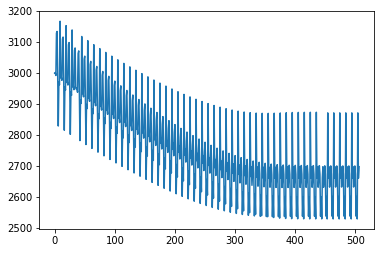

In [0]:
plt.plot(saved_loss)

## Prediction (IMPLEMENTATION)

In [0]:
def final_predictions(x, y, x_tk, y_tk, input_model):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    """ 
    # TODO: Train neural network using model_final
    model = input_model
    x = english_tokenizer.texts_to_sequences([x])
    x = pad(x, 21).T
    return model.predict(x.reshape(1, 21, 1))

val = final_predictions("new jersey is sometimes quiet during autumn , and it is snowy in april .", preproc_french_sentences, english_tokenizer, french_tokenizer, bd_model)

In [0]:
logits = [[np.argmax(val[0][i]) for i in range(21)]]

In [0]:
french_tokenizer.sequences_to_texts(logits)

## Submission
When you're ready to submit, complete the following steps:
1. Review the [rubric](https://review.udacity.com/#!/rubrics/1004/view) to ensure your submission meets all requirements to pass
2. Generate an HTML version of this notebook

  - Run the next cell to attempt automatic generation (this is the recommended method in Workspaces)
  - Navigate to **FILE -> Download as -> HTML (.html)**
  - Manually generate a copy using `nbconvert` from your shell terminal
```
$ pip install nbconvert
$ python -m nbconvert machine_translation.ipynb
```
  
3. Submit the project

  - If you are in a Workspace, simply click the "Submit Project" button (bottom towards the right)
  
  - Otherwise, add the following files into a zip archive and submit them 
  - `helper.py`
  - `machine_translation.ipynb`
  - `machine_translation.html`
    - You can export the notebook by navigating to **File -> Download as -> HTML (.html)**.

In [0]:
!!python -m nbconvert *.ipynb

## Optional Enhancements

This project focuses on learning various network architectures for machine translation, but we don't evaluate the models according to best practices by splitting the data into separate test & training sets -- so the model accuracy is overstated. Use the [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to create separate training & test datasets, then retrain each of the models using only the training set and evaluate the prediction accuracy using the hold out test set. Does the "best" model change?